In [263]:
import numpy as np
import numpy.ma as ma
import glob
import pandas as pd
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mplcolors

from sklearn import preprocessing
import scipy.interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import binned_statistic

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report

import lime
import lime.lime_tabular

In [307]:
def color_list(num_bins, cmap='seismic'):
    cmap = cm.get_cmap(cmap, num_bins-1)
    colors = []
    for i in range(cmap.N):
        rgba = cmap(i)
        # rgb2hex accepts rgb or rgba
        colors.append(mplcolors.rgb2hex(rgba))

    return colors

# Preparing the data

Prior to this notebook, I ran two scripts:

* demo_files.py
* gridding-grib2.py

The first reads the NUCAPS data in, does the surface correction, calculates CAPE, extracts some (possibly) useful metrics and metadata, and saves it to an npz file. The second script reopens the first, and using the Herbie package, appends HRRR surface CAPE values to it. I am so very glad more data like the HRRR is being moved to AWS...

Things are stored in daily files, so I have to put them together. Concatenating was the easiest method scripting wise, but the slowest. So I only kept items where there was CAPE observed in the ground truth (aka the HRRR). I set a minimum of 100 to ignore the small stuff. I am also ignoring failed retrievals, while some of these aren't terrible, have too much uncertainty for me to recommend them for regular use.

Since my science question is "What causes NUCAPS to deviate from the HRRR?" I took the difference between NUCAPS and the HRRR (predicted - actual) to show the error.

In [3]:
files = glob.glob('hrrr_matches/hwt_2022/*.csv')

In [4]:
df = pd.DataFrame()

for file in files:
    df_temp = pd.read_csv(file)

    # Only keep qc'd values, cases where there is actually CAPE
    qf_mask = (df_temp.qf == 0)
    cape_mask = (df_temp.hrrr_cape > 100)
    df_temp = df_temp[qf_mask & cape_mask]

    df = pd.concat([df, df_temp], ignore_index=True)

In [319]:
df['diff'] = df['nucaps_cape']-df['hrrr_cape']

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hrrr_time       20885 non-null  object 
 1   nucaps_lat      20885 non-null  float64
 2   nucaps_lon      20885 non-null  float64
 3   nucaps_cape     20885 non-null  float64
 4   qf              20885 non-null  float64
 5   view_angle      20885 non-null  float64
 6   cloud_frac      20885 non-null  float64
 7   ampl_eta_final  20885 non-null  float64
 8   Aeff_final      20885 non-null  float64
 9   A0_cloud        20885 non-null  float64
 10  chi2_cloud      20885 non-null  float64
 11  chi2temp        20885 non-null  float64
 12  chi2watr        20885 non-null  float64
 13  dof_temp        20885 non-null  float64
 14  dof_watr        20885 non-null  float64
 15  hrrr_lat        20885 non-null  float64
 16  hrrr_lon        20885 non-null  float64
 17  hrrr_cape       20885 non-null 

# Quick look at data
My first inspection of the data doesn't look very promising - NUCAPS CAPE deviates quite a bit from the HRRR. The number of large values was especially concerning, because past work showed underestimates of CAPE, not overestimates. However, I don't know what version of NUCAPS these studies and assessments used. I went back and doubel checked my surface adjustment (looked okay). I also checked with the NPROVS team to see if they also showed high CAPE, but no I didn't see it. However, I think the NPROVS team uses a different surface correction (I'll have to gently ask about this).

This is going to be fun...

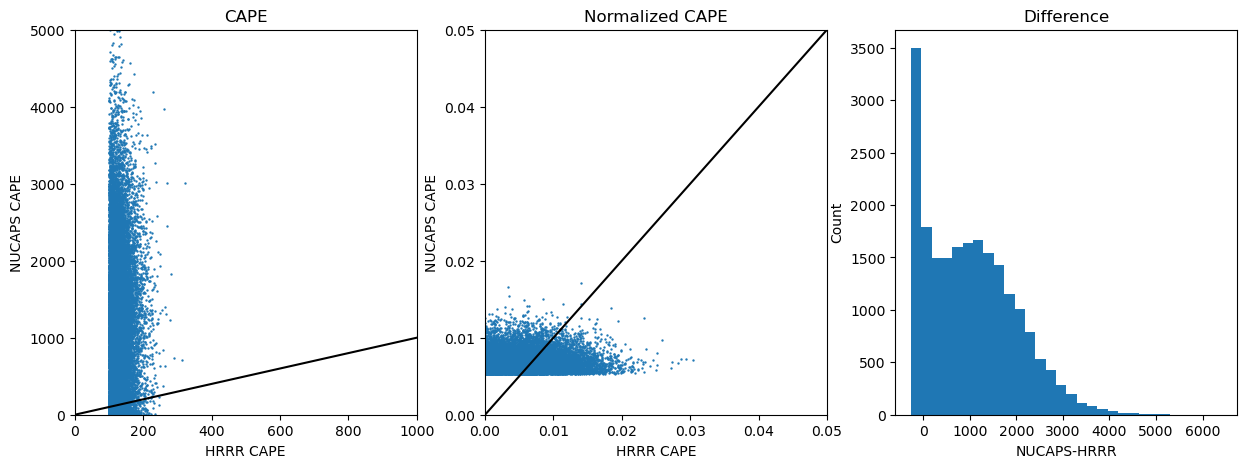

In [259]:
normalized_nucaps = preprocessing.normalize([data.nucaps_cape.values])
normalized_hrrr = preprocessing.normalize([data.hrrr_cape.values])

mask1 = (data.nucaps_cape > 0) & (data.hrrr_cape > 0)
mask2 = (normalized_nucaps > 0) & (normalized_hrrr > 0)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[15,5])

axes[0].set_title('CAPE')
axes[0].scatter(data.hrrr_cape.values[mask1], data.nucaps_cape.values[mask1], s=.5)
axes[0].plot([0,5000], [0,5000], color='k')
axes[0].set_xlim(0, 1000)
axes[0].set_ylim(0, 5000)
axes[0].set_xlabel("HRRR CAPE")
axes[0].set_ylabel("NUCAPS CAPE")

axes[1].set_title('Normalized CAPE')
axes[1].scatter(normalized_nucaps[mask2], normalized_hrrr[mask2], s=.5)
axes[1].plot([0,1], [0,1], color='k')
axes[1].set_xlim(0,0.05)
axes[1].set_ylim(0,0.05)
axes[1].set_xlabel("HRRR CAPE")
axes[1].set_ylabel("NUCAPS CAPE")

axes[2].set_title('Difference')
axes[2].hist(data['nucaps_cape']-data['hrrr_cape'], bins=30)
# axes[2].set_xlim(-300, 5000)
axes[2].set_xlabel("NUCAPS-HRRR")
axes[2].set_ylabel("Count")

plt.show()

# Defining the independent and dependant variables

I saved a number of diagnostic parameters along with the CAPE values. Some of them are more difficult to explain/understand than others, but on my first pass I included all of them. My hypothesis is that one or more of the diagnostic parameters can predict the residual in some way. Translating the diagnostic paramters to "real life" is also difficult, but depending on which diagnostic parameters (again, if any) are predictors of the error, I might be able determine the kinds of scenarios. Worst case, perhaps we can adjust the QC flag or make a new one.

Note that the diagnostics have been normalized, this is SOP for ML and analytics. The scales were fairly different on most of the values.

In [358]:
data = df

feature_names = ['view_angle','cloud_frac','ampl_eta_final','Aeff_final','A0_cloud','chi2_cloud', 'chi2temp', 'chi2watr', 'dof_temp', 'dof_watr']
feature_names = ['view_angle','ampl_eta_final','Aeff_final','chi2_cloud', 'chi2temp', 'chi2watr']
X = data[feature_names]

x = StandardScaler().fit_transform(X)
y = pd.DataFrame(data['diff'], columns=['diff'])

# Looking at the correlation matrix
[Principal component analysis (pca) with python examples tutorial](https://pub.towardsai.net/principal-component-analysis-pca-with-python-examples-tutorial-67a917bae9aa_)

There are a lot of parameters and I suspect many are hightly correlated. I iterated through the full list of parameters; the first time I found that DOFs had a large negative correlation with the other metrics whereas chi2 didn't. I dropped those. I also found that A0_cloud and chi2_cloud were correlated, but chi2 was less correlated with other vars, so I dropped A0_cloud; and so on. 

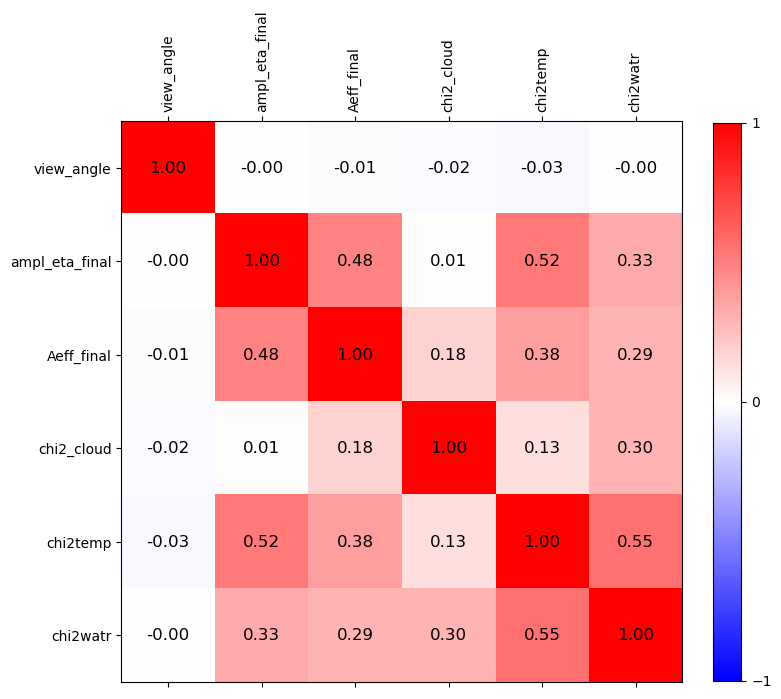

In [214]:
cov_data = np.corrcoef(np.array(x).T)

plt.figure(figsize=(8,8))
img = plt.matshow(cov_data, cmap=plt.cm.bwr, fignum=1, vmin=-1, vmax=1)
plt.colorbar(img, ticks = [-1.0, 0, 1.0], fraction=0.045)
for x in range(cov_data.shape[0]):
    for y in range(cov_data.shape[1]):
        plt.text(x, y, "%0.2f" % cov_data[x,y], size=12, color='black', ha="center", va="center")

ax = plt.gca()
plt.xticks(np.arange(0, cov_data.shape[0]))
plt.yticks(np.arange(0, cov_data.shape[0]))

ax.set_yticklabels(list(X.columns))
ax.set_xticklabels(list(X.columns))

plt.xticks(rotation=90)
plt.show()

# PCA
References:
* [PCA using Python](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)
* [Be careful with your principal components](https://onlinelibrary.wiley.com/doi/10.1111/evo.13835)

I'm employing principle component analysis to see we can, in fact, explain the error using the selected diagnostics. Below, I define the number dimensions I want to reduce the dataset too. I am starting with 10, redued to 6, and using PCA, widdle down to 3. Note that the components themselves really don't have meaning, but rather just says how much we can ideally be able to explain variabce in the data.

In [301]:
num_comp = 3
pca = PCA(n_components=num_comp)
principalComponents = pca.fit_transform(x)
pca_cols = ['PC'+str(i+1).zfill(2) for i in np.arange(0, num_comp)]
principalDf = pd.DataFrame(data = principalComponents, columns = pca_cols)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

[0.39173407 0.17516227 0.16645773] 0.7333540692233482


After running the code above, the cell prints the explained variance for each component. The sum represents the total variance explained when you add/remove components. My PC1 store decreased and my PC2 and PC3 stores increased after I reduced the number of diagnostic parameters (and total explained variance increased as a result).

* 10 vars: [0.42294317 0.13782273 0.10222424] *0.6629901394955646*
* 6 vars: [0.39173407 0.17516227 0.16645773] *0.7333540692233479*

The PCA still doesn't look at the dependent variable (error in NUCAPS CAPE). We can quickly look at the relationship between the errors and the principle components by grouping into bins. The most obvious thing I tried was the error itself, but there was not any correlation. However, I found something interested by grouping by cloud fraction in the original dataframe (remember, the number of columsn change, not rows, so we can filter by the original df is the order remains the same):

In [338]:
num_bins = 6
bin_var = data['diff']
min_value = bin_var.min()
max_value = bin_var.max()
bins = np.linspace(min_value, max_value, num_bins)

labels = ['bin_'+str(i) for i in np.arange(0, num_bins-1)]
colors = color_list(num_bins, cmap='viridis')
y['bins'] = pd.cut(bin_var, bins=bins, labels=labels, include_lowest=True)
finalDf = pd.concat([principalDf, y ], axis = 1)

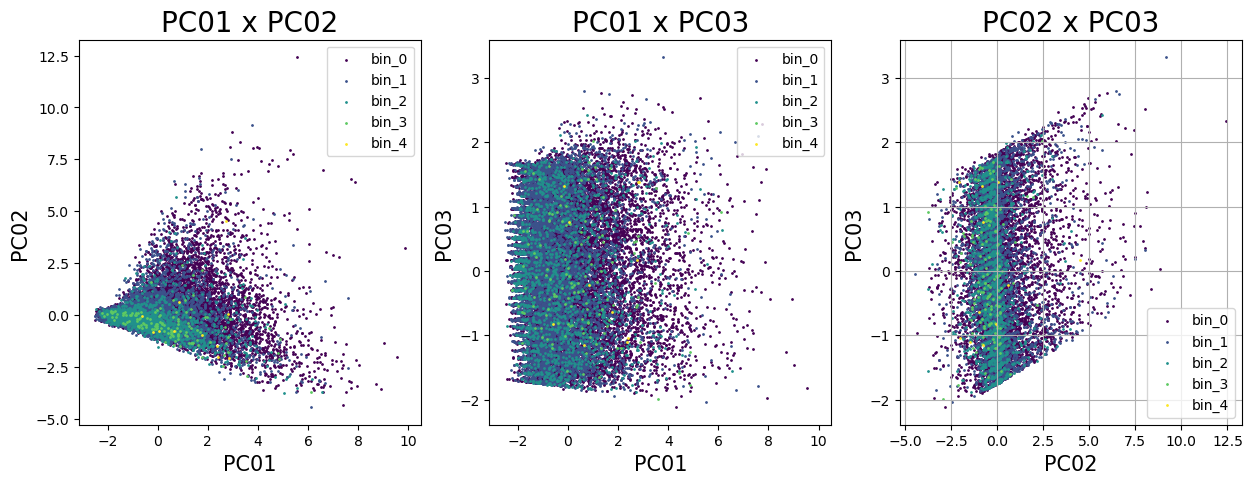

In [344]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1,3,1) 
ax.set_xlabel('PC01', fontsize = 15)
ax.set_ylabel('PC02', fontsize = 15)
ax.set_title('PC01 x PC02', fontsize = 20)

for target, color in zip(labels, colors):
    indicesToKeep = finalDf['bins'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC01']
               , finalDf.loc[indicesToKeep, 'PC02']
               , c = color
               , s = 1)
ax.legend(labels)

ax = fig.add_subplot(1,3,2) 
ax.set_xlabel('PC01', fontsize = 15)
ax.set_ylabel('PC03', fontsize = 15)
ax.set_title('PC01 x PC03', fontsize = 20)

for target, color in zip(labels, colors):
    indicesToKeep = finalDf['bins'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC01']
               , finalDf.loc[indicesToKeep, 'PC03']
               , c = color
               , s = 1)
ax.legend(labels)


ax = fig.add_subplot(1,3,3) 
ax.set_xlabel('PC02', fontsize = 15)
ax.set_ylabel('PC03', fontsize = 15)
ax.set_title('PC02 x PC03', fontsize = 20)

for target, color in zip(labels, colors):
    indicesToKeep = finalDf['bins'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC02']
               , finalDf.loc[indicesToKeep, 'PC03']
               , c = color
               , s = 1)
ax.legend(labels)


ax.grid()

# Random Forest Regressor
Resources:
* [Introduction to Explainable AI(XAI) using LIME](https://www.geeksforgeeks.org/introduction-to-explainable-aixai-using-lime/)
* [Evaluating a Random Forest model](https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56)
* [A Quick and Dirty Guide to Random Forest Regression](https://towardsdatascience.com/a-quick-and-dirty-guide-to-random-forest-regression-52ca0af157f8)

Regardless of technique, we need to split the data into testing and training groups. Scikitlearn has some helpful functions to do that.

In [347]:
X_train, X_test, y_train, y_test = train_test_split(x, y['diff'], test_size = 0.3, random_state = 1)

It's stupid easy to code up a machine learning model, which is both convenient and terrifying:

In [348]:
model = RandomForestRegressor(max_depth=3, random_state=1, n_estimators=10)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=10, random_state=1)

Below I predict the y values based on the test dataset. After that, we compute the MSE and the RMSE for the model.

In [353]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)**(0.5)
print(mse, mse**.5)

870.3153001868062 29.50110676206583


# Explainable AI

One of my learning goals was to understand explainable AI a bit more. The Local  Interpretable Model-agnostic Explanations (LIME) technique can be paired with a machine learning model by passing a single case in and seeing the impact of various prectitors on the dependent variable. It's kind of neat and it could be interesting for this study if it makes sense to employ ML here (over traditional, and thereby interpretable, statistics).

First you start by defining the explainer, which can be either a regression or a classification.

In [359]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=['difference_cape'], verbose=True, mode='regression')

Then you pass in a single data point. I like this approach because it reminds me of a "case study," and I can deep dive a specific event.

In [361]:
j = 1266
j = 1716
exp = explainer.explain_instance(X_test[j], model.predict, num_features=20)
exp.show_in_notebook(show_table=True)

Intercept 851.1260291033145
Prediction_local [1479.60433539]
Right: 1282.0589638485637
